## Environment Setup

In [1]:
import json
import pandas as pd
import numpy as np
from glob import glob
import re

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
%matplotlib inline



## Convert JSON to Pandas DF

In [2]:
extract_info = ['name','city','state','postal_code','stars','review_count', 'categories','attributes']
value_ls = []
dollar_sign = []
# extract_info1 = ['attributes']  
with open ('business.json') as json_file:
    for line in json_file:
        ob = json.loads(line)
        
        ob_new  = dict((k, ob[k]) for k in extract_info if k in ob)
        value_ls.append(list(ob_new.values()))
    json_file.close()
    df_raw = pd.DataFrame(value_ls, columns = extract_info)

In [3]:
df_raw.head(5)

,name,city,state,postal_code,stars,review_count,categories,attributes
0,Arizona Biltmore Golf Club,Phoenix,AZ,85016,3.0,5,"Golf, Active Life",{'GoodForKids': 'False'}
1,Emerald Chinese Restaurant,Mississauga,ON,L5R 3E7,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...","{'RestaurantsReservations': 'True', 'GoodForMe..."
2,Musashi Japanese Restaurant,Charlotte,NC,28210,4.0,170,"Sushi Bars, Restaurants, Japanese","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera..."
3,Farmers Insurance - Paul Lorenz,Goodyear,AZ,85338,5.0,3,"Insurance, Financial Services",None
4,Queen City Plumbing,Charlotte,NC,28217,4.0,4,"Plumbing, Shopping, Local Services, Home Servi...","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint..."


In [4]:
def restaurant_checker(categories):
    if categories == None:
        return False
    
    if ('Restaurants' in categories.split(', '))|('*Food' in categories.split(', ')):
        return True
    return False

df_raw['restaurant'] = df_raw['categories'].apply(restaurant_checker)

In [5]:
# extract resutrants out of raw list
df_res = df_raw[df_raw.restaurant == True]
df_res.head(10)

,name,city,state,postal_code,stars,review_count,categories,attributes,restaurant
1,Emerald Chinese Restaurant,Mississauga,ON,L5R 3E7,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...","{'RestaurantsReservations': 'True', 'GoodForMe...",True
2,Musashi Japanese Restaurant,Charlotte,NC,28210,4.0,170,"Sushi Bars, Restaurants, Japanese","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",True
11,Taco Bell,Phoenix,AZ,85016,3.0,18,"Restaurants, Breakfast & Brunch, Mexican, Taco...","{'RestaurantsTakeOut': 'True', 'BusinessParkin...",True
13,Marco's Pizza,Mentor-on-the-Lake,OH,44060,4.0,16,"Italian, Restaurants, Pizza, Chicken Wings","{'RestaurantsPriceRange2': '2', 'BusinessAccep...",True
17,Carluccio's Tivoli Gardens,Las Vegas,NV,89119,4.0,40,"Restaurants, Italian","{'OutdoorSeating': 'False', 'BusinessAcceptsCr...",True
23,Marathon Diner,Pittsburgh,PA,15231,4.0,35,"Sandwiches, Salad, Restaurants, Burgers, Comfo...","{'RestaurantsTakeOut': 'True', 'BusinessParkin...",True
25,Maria's Mexican Restaurant & Bakery,Las Vegas,NV,89156,4.5,184,"Mexican, Restaurants, Patisserie/Cake Shop, Fo...","{'BikeParking': 'True', 'BusinessParking': '{'...",True
29,Bolt Fresh Bar,Toronto,ON,M6J 1J5,3.0,57,"Juice Bars & Smoothies, Food, Restaurants, Fas...","{'WiFi': 'u'no'', 'BikeParking': 'True', 'Rest...",True
32,The Steady Cafe & Bar,Toronto,ON,M6H 1M4,3.5,29,"Restaurants, Nightlife, Breakfast & Brunch, Ve...","{'BusinessParking': '{'garage': False, 'street...",True
35,Manzetti's Tavern,Charlotte,NC,28211,3.5,16,"Sandwiches, Italian, American (Traditional), A...","{'Alcohol': 'u'full_bar'', 'BusinessAcceptsCre...",True


In [6]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59371 entries, 1 to 192603
Data columns (total 9 columns):
name            59371 non-null object
city            59371 non-null object
state           59371 non-null object
postal_code     59371 non-null object
stars           59371 non-null float64
review_count    59371 non-null int64
categories      59371 non-null object
attributes      57161 non-null object
restaurant      59371 non-null bool
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 4.1+ MB


In [7]:
# df_res.loc[1 ,'attributes'].keys()


In [8]:
## extract dollar sign info from attributes
def dollar_sign(attributes):
    
    if attributes == None:
        return None
    
    elif 'RestaurantsPriceRange2' in attributes.keys():
        return attributes['RestaurantsPriceRange2']
    return None

df_res['DollarSigns'] = df_res['attributes'].apply(dollar_sign)        

/Users/vsu/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [9]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59371 entries, 1 to 192603
Data columns (total 10 columns):
name            59371 non-null object
city            59371 non-null object
state           59371 non-null object
postal_code     59371 non-null object
stars           59371 non-null float64
review_count    59371 non-null int64
categories      59371 non-null object
attributes      57161 non-null object
restaurant      59371 non-null bool
DollarSigns     52091 non-null object
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 4.6+ MB


In [10]:
df_res = df_res.sort_values(['state','city','postal_code'])
df_res = df_res.drop(columns=['restaurant'])
df_res

,name,city,state,postal_code,stars,review_count,categories,attributes,DollarSigns
63229,Little Caesars Pizza,Airdrie,AB,T3A 0K9,1.5,3,"Restaurants, Food, Pizza","{'BusinessParking': '{'garage': False, 'street...",1
79669,A Perfect Pizza,Airdrie,AB,T4A,2.0,7,"Restaurants, Pizza","{'RestaurantsPriceRange2': '2', 'RestaurantsAt...",2
146453,Creekside Chinese,Airdrie,AB,T4A,3.0,5,"Restaurants, Buffets, Chinese","{'RestaurantsTableService': 'True', 'HasTV': '...",None
126700,Mio Stone Grill & Sushi,Airdrie,AB,T4A 0B1,5.0,31,"Restaurants, Japanese, Sushi Bars, Food","{'OutdoorSeating': 'False', 'RestaurantsTakeOu...",2
160068,Toad 'n' Turtle Pubhouse,Airdrie,AB,T4A 0B1,3.0,20,"Nightlife, Pubs, Bars, Gastropubs, Restaurants","{'Caters': 'True', 'Ambience': '{'romantic': F...",2
20478,Tony's Vietnamese Noodle Restaurant,Airdrie,AB,T4A 0E1,4.0,25,"Vegetarian, Restaurants, Soup, Vietnamese","{'HasTV': 'True', 'Ambience': '{'romantic': Fa...",1
36416,IL Forno,Airdrie,AB,T4A 0E1,4.5,19,"Restaurants, Italian, Pizza","{'RestaurantsPriceRange2': '3', 'RestaurantsDe...",3
23007,Rice for King,Airdrie,AB,T4A 0K9,3.0,5,"Restaurants, Vietnamese","{'RestaurantsPriceRange2': '2', 'BusinessParki...",2
64610,State & Main,Airdrie,AB,T4A 0K9,2.5,11,"Restaurants, Sports Bars, Pubs, Sandwiches, Ni...",{'DriveThru': 'False'},None
114452,Cena Tabella,Airdrie,AB,T4A 0R8,3.0,6,"Pizza, Italian, Restaurants","{'WiFi': 'u'free'', 'Alcohol': 'u'beer_and_win...",2


### Extract US Part

In [9]:
US = ['AL',	'AK',	'AZ',	'AR',	'CA',	'CO',	'CT',	'DE',	'FL',	'GA',	'HI',	'ID',	'IL',	'IN',	'IA',	'KS',	'KY',	'LA',	'ME',	'MD',	'MA',	'MI',	'MN',	'MS',	'MO',	'MT',	'NE',	'NV',	'NH',	'NJ',	'NM',	'NY',	'NC',	'ND',	'OH',	'OK',	'OR',	'PA',	'RI',	'SC',	'SD',	'TN',	'TX',	'UT',	'VT',	'VA',	'WA',	'WV',	'WI',	'WY',]
US_1 = []
for x in US:
    US_1.append(x.strip())

In [10]:
df_US = df_res[df_res.state.isin(US_1)]
df_US.state.unique()

array(['NC', 'AZ', 'OH', 'NV', 'PA', 'WI', 'IL', 'NY', 'SC', 'NM', 'VA',
       'NE', 'CA', 'WA', 'TX', 'VT', 'AR', 'FL', 'AL'], dtype=object)

In [11]:
df_US.groupby('state').count()  # AZ has the most data

,name,city,postal_code,stars,review_count,categories,attributes,restaurant,DollarSigns
state,,,,,,,,,
AL,1,1,1,1,1,1,0,1,0
AR,1,1,1,1,1,1,1,1,1
AZ,11465,11465,11465,11465,11465,11465,11207,11465,10586
CA,1,1,1,1,1,1,1,1,1
FL,1,1,1,1,1,1,1,1,1
IL,672,672,672,672,672,672,649,672,605
NC,4326,4326,4326,4326,4326,4326,4178,4326,3843
NE,1,1,1,1,1,1,1,1,0
NM,1,1,1,1,1,1,1,1,1


In [12]:
df_AZ = df_US[df_US.state =='AZ']
df_AZ.city.unique()

array(['Phoenix', 'Chandler', 'Scottsdale', 'Mesa', 'Peoria', 'Glendale',
       'Cave Creek', 'Surprise', 'Goodyear', 'Gilbert', 'Sun City',
       'Avondale', 'Tempe', 'Paradise Valley', 'Fountain Hills',
       'Sun Lakes', 'Fort Mcdowell', 'Laveen', 'Litchfield Park',
       'Buckeye', 'Sun City West', 'Fort McDowell', 'Tolleson',
       'Queen Creek', 'Somerton', 'El Mirage', 'Carefree', 'Ahwatukee',
       'PHOENIX', 'Anthem', 'Glendale Az', 'Apache Junction',
       'SCOTTSDALE', 'Gelndale', 'Guadalupe', 'Youngtown', 'Sedona',
       'Schottsdale', 'Mesa AZ', 'Laveen Village', 'cave creek', 'mesa',
       'Higley', 'MESA', 'Scottdale', 'Waddell', 'Phx', 'Pheonix',
       'Maricopa', 'GILBERT', 'Central City', 'Central City Village',
       'Pheonix AZ', 'Rio Verde', 'GOODYEAR', 'Phoenix Valley', 'Central'],
      dtype=object)

In [13]:
df_AZ = df_AZ.drop(columns = ['stars', 'categories','attributes'])

In [14]:
df_AZ.head(5)
df_AZ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11465 entries, 11 to 192532
Data columns (total 7 columns):
name            11465 non-null object
city            11465 non-null object
state           11465 non-null object
postal_code     11465 non-null object
review_count    11465 non-null int64
restaurant      11465 non-null bool
DollarSigns     10586 non-null object
dtypes: bool(1), int64(1), object(5)
memory usage: 638.2+ KB


In [15]:
# int(df_AZ.DollarSigns.loc[16155])*'$'
def num_to_dollar(x):
    try:
        return int(x)*'$'
    except:
        return None

df_AZ['Dollar_Sign'] = df_AZ['DollarSigns'].apply(num_to_dollar)
df_AZ= df_AZ.drop(columns = ['DollarSigns'])
df_AZ

,name,city,state,postal_code,review_count,restaurant,Dollar_Sign
11,Taco Bell,Phoenix,AZ,85016,18,True,$
78,Nee House Chinese Restaurant,Phoenix,AZ,85032,269,True,$$
133,Vals Getaway DES Cafeteria,Phoenix,AZ,85007,14,True,$
140,Vintage 95,Chandler,AZ,85225,320,True,$$
146,New Mexican Grill,Chandler,AZ,85286,84,True,$
...,...,...,...,...,...,...,...
192450,Razzleberriez Frozen Yogurt,Peoria,AZ,85383,21,True,$
192459,Dog Town Chili Dogs,Tempe,AZ,85281,6,True,$
192463,Pomo Pizzeria Gilbert,Gilbert,AZ,85234,337,True,$$
192501,Smashburger,Mesa,AZ,85215,151,True,$


In [16]:
df_AZ = df_AZ.rename(columns = {'name':'Restaurant_Name','city':'City',
              'state':'State','review_count':'Num_of_Review',
              'postal_code':'ZipCode'})

df_AZ = df_AZ.dropna(subset= ['City','Dollar_Sign','ZipCode','Num_of_Review'])


In [17]:
df_AZ.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10582 entries, 11 to 192532
Data columns (total 7 columns):
Restaurant_Name    10582 non-null object
City               10582 non-null object
State              10582 non-null object
ZipCode            10582 non-null object
Num_of_Review      10582 non-null int64
restaurant         10582 non-null bool
Dollar_Sign        10582 non-null object
dtypes: bool(1), int64(1), object(5)
memory usage: 589.0+ KB


## Import CSV files - Census info and Webscraping from Yelp

In [18]:
# Yelp info
df_scrap_raw = pd.read_csv('Scrapping/yelp_info_final_partial1.csv')
df_scrap_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39405 entries, 0 to 39404
Data columns (total 11 columns):
Unnamed: 0          39405 non-null int64
Restaurant_Name     39405 non-null object
Phone_Number        39347 non-null object
Address             38622 non-null object
Number_of_Review    39035 non-null object
Dollar_Sign         35213 non-null object
URL                 39405 non-null object
Address.1           38622 non-null object
City                38621 non-null object
State               38622 non-null object
Zipcode             38612 non-null float64
dtypes: float64(1), int64(1), object(9)
memory usage: 3.3+ MB


In [19]:
df_scrap_raw.sample(1)

,Unnamed: 0,Restaurant_Name,Phone_Number,Address,Number_of_Review,Dollar_Sign,URL,Address.1,City,State,Zipcode
34822,34823,Brothers Shabuhouse,(323) 465-6688,"210N Western Ave,Ste 103,Los Angeles, CA 90004",69 reviews,$$,www.yelp.com/biz/brothers-shabuhouse-los-angel...,"210N Western Ave,Ste 103,Los Angeles, CA 90004",Los Angeles,CA,90004.0


In [20]:
df_scrap_raw.dropna(subset=['Number_of_Review', 'Dollar_Sign','Address','City','Zipcode'],inplace = True)
df_scrap_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34821 entries, 0 to 39404
Data columns (total 11 columns):
Unnamed: 0          34821 non-null int64
Restaurant_Name     34821 non-null object
Phone_Number        34821 non-null object
Address             34821 non-null object
Number_of_Review    34821 non-null object
Dollar_Sign         34821 non-null object
URL                 34821 non-null object
Address.1           34821 non-null object
City                34821 non-null object
State               34821 non-null object
Zipcode             34821 non-null float64
dtypes: float64(1), int64(1), object(9)
memory usage: 3.2+ MB


In [21]:
df_scrap_raw.drop_duplicates(subset = ['Phone_Number', 'Address'], keep = 'first', inplace=True)
df_scrap_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21325 entries, 0 to 39404
Data columns (total 11 columns):
Unnamed: 0          21325 non-null int64
Restaurant_Name     21325 non-null object
Phone_Number        21325 non-null object
Address             21325 non-null object
Number_of_Review    21325 non-null object
Dollar_Sign         21325 non-null object
URL                 21325 non-null object
Address.1           21325 non-null object
City                21325 non-null object
State               21325 non-null object
Zipcode             21325 non-null float64
dtypes: float64(1), int64(1), object(9)
memory usage: 2.0+ MB


In [22]:
# Cleanup
df_scrap_raw.drop(columns = ['Unnamed: 0','URL','Phone_Number', 'Address.1', 'Address'],inplace = True)
df_scrap_raw.head(5)

,Restaurant_Name,Number_of_Review,Dollar_Sign,City,State,Zipcode
0,Angela’s Kitchen,208 reviews,$$,Alameda,CA,94501.0
1,Ohgane KBBQ - Alameda,139 reviews,$$,Alameda,CA,94501.0
2,Trabocco Kitchen & Cocktails,1200 reviews,$$,Alameda,CA,94501.0
3,Sidestreet Pho,765 reviews,$$,Alameda,CA,94501.0
4,Wild Ginger,266 reviews,$$,Alameda,CA,94501.0


In [23]:
# remove "reviews" 
df_scrap_raw['Num_of_Review'] = df_scrap_raw['Number_of_Review'].apply(lambda x: int(x.split()[0]))
df_scrap_raw.drop(columns =['Number_of_Review'], inplace = True)

In [24]:
#remove city whitespace
df_scrap_raw['City'] = df_scrap_raw['City'].apply(lambda x: x.rstrip())

In [25]:
# change zipcode to string
df_scrap_raw['ZipCode'] = df_scrap_raw['Zipcode'].apply(lambda x: str(int(x)))
df_scrap_raw.drop(columns =['Zipcode'], inplace = True)

In [26]:
# #convert DolalrSign to number [1,2,3,4]
# df_scrap_raw['DollarSigns'] = df_scrap_raw['Dollar_Sign'].apply(lambda x: int(len(x)))
# df_scrap_raw.drop(columns =['Dollar_Sign'], inplace = True)

In [27]:
df_scrap_raw.Dollar_Sign.value_counts()

$$      14122
$        5866
$$$      1137
$$$$      200
Name: Dollar_Sign, dtype: int64

In [28]:
# combine df_AZ with scraping dataset
df_scrap_raw_X = pd.concat([df_scrap_raw, df_AZ], sort = False)
df_scrap_raw_X.sample(5)

,Restaurant_Name,Dollar_Sign,City,State,Num_of_Review,ZipCode,restaurant
13215,Americano,$$,Livermore,CA,299,94550,NaN
28417,Grille 101,$$,San Rafael,CA,31,94903,NaN
141710,Central Wine,$$,Phoenix,AZ,72,85012,True
12072,The Cheesecake Factory,$$,Irvine,CA,1246,92618,NaN
7516,Hawaiian Drive Inn,$,South San Francisco,CA,200,94080,NaN


In [29]:
df_scrap_raw_X.drop_duplicates(subset = ['Restaurant_Name', 'Dollar_Sign','ZipCode','Num_of_Review'],
                               keep = 'first', inplace=True)

## Create Dummy for dollar signs category

In [30]:
X = pd.get_dummies(df_scrap_raw_X.Dollar_Sign)
df_res = df_scrap_raw_X.join(X)
df_res = df_res.rename(columns={'$': 'D1', '$$': 'D2','$$$': 'D3','$$$$': 'D4'})
df_res = df_res.drop_duplicates(subset = ['Restaurant_Name', 'Dollar_Sign','ZipCode','Num_of_Review'],
                               keep = 'first')
df_res.sample(5)

,Restaurant_Name,Dollar_Sign,City,State,Num_of_Review,ZipCode,restaurant,D1,D2,D3,D4
3965,Mister Bossam,$$,Los Angeles,CA,588,90020,NaN,0,1,0,0
158217,Echo Coffee,$,Scottsdale,AZ,397,85251,True,1,0,0,0
11793,Shabu On Fire,$$,Huntington Beach,CA,223,92648,NaN,0,1,0,0
15179,El Huarachito,$,Los Angeles,CA,605,90031,NaN,1,0,0,0
11516,Surf City Fish Grill,$$,Huntington Beach,CA,319,92647,NaN,0,1,0,0


In [31]:
df_res.State.unique()
# df_res[df_res.State != 'CA'].City.unique()

array(['CA', 'AZ', 'AR', 'NV', 'WA', 'CO', 'TX'], dtype=object)

In [32]:
df_city_review1 = df_res[df_res.Dollar_Sign =='$'].groupby(['State','City']).median().drop(columns = ['D1','D2','D3','D4'])
df_city_review2 = df_res[df_res.Dollar_Sign =='$$'].groupby(['State','City']).median().drop(columns = ['D1','D2','D3','D4'])
df_city_review3 = df_res[df_res.Dollar_Sign =='$$$'].groupby(['State','City']).median().drop(columns = ['D1','D2','D3','D4'])
df_city_review4 = df_res[df_res.Dollar_Sign =='$$$$'].groupby(['State','City']).median().drop(columns = ['D1','D2','D3','D4'])

print(df_city_review1.count(), df_city_review2.count(),df_city_review3.count(),df_city_review4.count())

Num_of_Review    272
dtype: int64 Num_of_Review    357
dtype: int64 Num_of_Review    183
dtype: int64 Num_of_Review    78
dtype: int64


In [33]:
df_city = df_res.groupby(['State','City']).agg({'Num_of_Review':'mean','D1':'sum','D2':'sum','D3':'sum','D4':'sum'}).reset_index()
df_city.count()

State            409
City             409
Num_of_Review    409
D1               409
D2               409
D3               409
D4               409
dtype: int64

In [34]:
result = pd.merge(df_city, df_city_review1['Num_of_Review'], on=['State','City'],how = 'left')
result = result.rename(columns={'Num_of_Review_x': 'Total_Avg_Review', 'Num_of_Review_y': 'D1_Avg_Review'})

In [35]:
result.count()

State               409
City                409
Total_Avg_Review    409
D1                  409
D2                  409
D3                  409
D4                  409
D1_Avg_Review       272
dtype: int64

In [36]:
result = pd.merge(result, df_city_review2['Num_of_Review'], on=['State','City'],how = 'left')
result = result.rename(columns={'Num_of_Review': 'D2_Avg_Review'})


In [37]:
result = pd.merge(result, df_city_review3['Num_of_Review'], on=['State','City'],how = 'left')
result = result.rename(columns={'Num_of_Review': 'D3_Avg_Review'})
result = pd.merge(result, df_city_review4['Num_of_Review'], on=['State','City'],how = 'left')
result = result.rename(columns={'Num_of_Review': 'D4_Avg_Review'})
result.count()

State               409
City                409
Total_Avg_Review    409
D1                  409
D2                  409
D3                  409
D4                  409
D1_Avg_Review       272
D2_Avg_Review       357
D3_Avg_Review       183
D4_Avg_Review        78
dtype: int64

In [38]:
df_res = result.copy()

In [39]:
df_res.sample(5)

,State,City,Total_Avg_Review,D1,D2,D3,D4,D1_Avg_Review,D2_Avg_Review,D3_Avg_Review,D4_Avg_Review
18,AZ,Gelndale,9.000000,1.0,0.0,0,0,9.0,NaN,NaN,NaN
280,CA,San Leandro,226.000000,0.0,1.0,0,0,NaN,226.0,NaN,NaN
407,WA,Seattle,642.889145,29.0,331.0,59,14,347.0,398.0,605.0,590.0
394,WA,Bellevue,326.574468,40.0,174.0,18,3,144.0,239.5,485.5,636.0
230,CA,Oakland,391.732026,208.0,383.0,19,2,102.5,299.0,433.0,597.0


# Read in Median Household income and Population based on City

In [40]:
from pandas import ExcelWriter
from pandas import ExcelFile
df_income = pd.read_excel('Data/Census_cleaned.xlsx')
df_income.drop(columns = ['GEO_ID'], inplace = True)


In [41]:
df_copy = df_income.copy()
# df_income = df_copy
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 3 columns):
NAME                249 non-null object
Median_HH_Income    249 non-null int64
Population          249 non-null int64
dtypes: int64(2), object(1)
memory usage: 6.0+ KB


In [42]:
df_income['Name'] = df_income['NAME'].apply(lambda x: x.split(','))


In [43]:
def State(Name):
    try: 
        Name[1] == None
        return Name[1].strip()
    except: 
        return None
def City(Name):
    try: 
        Name[0] == None
        return " ".join(Name[0].strip().split(' ')[:-1])
    except:
        return None


df_income['State'] = df_income['Name'].apply(State)
df_income['City'] = df_income['Name'].apply(City)
df_income.drop(columns = ['Name','Name'], inplace = True)
df_income['City'] = df_income['City'].apply(lambda x : x.strip())
# df_income['City'] = df_income['State'].apply(lambda x : x[1])


In [44]:
df_income.dropna(subset=['State'], inplace = True)
df_income.info()
df_income.rename(columns = {'Median_HH_Income' : '2018_Median_Income', 'Population':'2017_Population'},inplace = True)
df_income.drop(columns=['NAME'], inplace = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 0 to 248
Data columns (total 5 columns):
NAME                249 non-null object
Median_HH_Income    249 non-null int64
Population          249 non-null int64
State               249 non-null object
City                249 non-null object
dtypes: int64(2), object(3)
memory usage: 11.7+ KB


In [45]:
df_income.State.unique()

array(['AZ', 'CA', 'NV', 'WA', 'TX'], dtype=object)

## Combine income and yelp info together

In [46]:
df_income.head(12)

,2018_Median_Income,2017_Population,State,City
0,63242,85828,AZ,Avondale
1,68655,74378,AZ,Buckeye
2,62927,75694,AZ,Casas Adobes
3,85527,257153,AZ,Chandler
4,58808,73955,AZ,Flagstaff
5,99866,248269,AZ,Gilbert
6,54789,250705,AZ,Glendale
7,89959,82837,AZ,GoodyeAZ
8,58247,508979,AZ,Mesa
9,72050,172272,AZ,Peoria


In [47]:
df_X = pd.merge(df_res, df_income, on=['State','City'],how = 'left')
df_X.sample(5)

,State,City,Total_Avg_Review,D1,D2,D3,D4,D1_Avg_Review,D2_Avg_Review,D3_Avg_Review,D4_Avg_Review,2018_Median_Income,2017_Population
380,NV,Kingsbury,12.000000,0.0,1.0,0,0,NaN,12.0,NaN,NaN,NaN,NaN
197,CA,Los Atlos,72.000000,0.0,1.0,0,0,NaN,72.0,NaN,NaN,NaN,NaN
317,CA,So. Lake Tahoe,81.000000,1.0,0.0,0,0,81.0,NaN,NaN,NaN,NaN,NaN
232,CA,Orange,865.208955,15.0,49.0,2,1,436.0,717.0,2407.0,482.0,87143.0,139502.0
33,AZ,Peoria,86.450151,164.0,159.0,7,1,30.5,66.0,114.5,NaN,72050.0,172272.0


In [48]:
df_X.dropna(subset=['Total_Avg_Review','2018_Median_Income','2017_Population'], inplace = True)

In [49]:
df_X.count()

State                 87
City                  87
Total_Avg_Review      87
D1                    87
D2                    87
D3                    87
D4                    87
D1_Avg_Review         81
D2_Avg_Review         86
D3_Avg_Review         63
D4_Avg_Review         42
2018_Median_Income    87
2017_Population       87
dtype: int64

In [50]:
df_X = df_X.reset_index()
df_X.fillna(value = 0, inplace = True)

In [51]:
df_X.drop(columns = ['index'], inplace = True)

In [52]:
df_X['Total_Res_count'] = (df_X['D1'] + df_X['D2'] + df_X['D3']+ df_X['D4'])

df_X

,State,City,Total_Avg_Review,D1,D2,D3,D4,D1_Avg_Review,D2_Avg_Review,D3_Avg_Review,D4_Avg_Review,2018_Median_Income,2017_Population,Total_Res_count
0,AZ,Avondale,71.797619,95.0,72.0,1,0,34.0,33.5,11.0,9.0,63242.0,85828.0,168.0
1,AZ,Buckeye,64.642857,6.0,8.0,0,0,46.5,54.0,0.0,0.0,68655.0,74378.0,14.0
2,AZ,Chandler,102.720245,383.0,411.0,18,3,35.0,100.0,50.0,28.0,85527.0,257153.0,815.0
3,AZ,Gilbert,124.702048,277.0,254.0,6,0,45.0,101.0,31.5,0.0,99866.0,248269.0,537.0
4,AZ,Glendale,80.883510,360.0,285.0,14,2,27.0,60.0,14.0,24.0,54789.0,250705.0,661.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,WA,Kirkland,273.096774,10.0,47.0,4,1,176.5,201.0,293.0,459.0,119844.0,89557.0,62.0
83,WA,Redmond,244.600000,21.0,82.0,2,0,146.0,189.5,378.0,0.0,134844.0,67680.0,105.0
84,WA,Renton,530.000000,0.0,2.0,1,0,0.0,277.5,1035.0,0.0,78023.0,102152.0,3.0
85,WA,Sammamish,195.666667,0.0,3.0,0,0,0.0,182.0,0.0,0.0,183038.0,65726.0,3.0


In [55]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 14 columns):
State                 87 non-null object
City                  87 non-null object
Total_Avg_Review      87 non-null float64
D1                    87 non-null float64
D2                    87 non-null float64
D3                    87 non-null uint8
D4                    87 non-null uint8
D1_Avg_Review         87 non-null float64
D2_Avg_Review         87 non-null float64
D3_Avg_Review         87 non-null float64
D4_Avg_Review         87 non-null float64
2018_Median_Income    87 non-null float64
2017_Population       87 non-null float64
Total_Res_count       87 non-null float64
dtypes: float64(10), object(2), uint8(2)
memory usage: 8.4+ KB


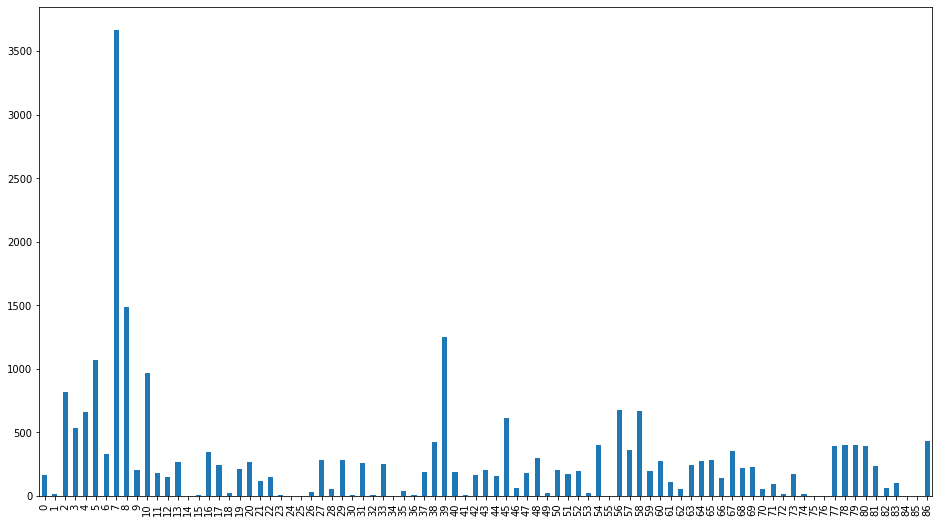

In [57]:
df_X.Total_Res_count.plot.bar(figsize = (16,9));

## Correlations

In [59]:
df_M = df_X

In [60]:
df_M.rename(columns = {'2018_Median_Income':'Median_Income_2018', '2017_Population':'Population_2017','Res/Population':'Res_div_Pop'},inplace = True)

In [61]:
df_M.sort_values(by=['Total_Res_count'], ascending=False)

,State,City,Total_Avg_Review,D1,D2,D3,D4,D1_Avg_Review,D2_Avg_Review,D3_Avg_Review,D4_Avg_Review,Median_Income_2018,Population_2017,Total_Res_count
7,AZ,Phoenix,111.547340,1918.0,1634.0,98,15,28.0,83.0,72.0,29.0,57957.0,1660272.0,3665.0
8,AZ,Scottsdale,147.926698,473.0,883.0,108,23,42.0,94.0,62.5,104.5,88071.0,255315.0,1487.0
39,CA,Los Angeles,762.023126,193.0,935.0,105,21,320.0,461.0,581.0,529.0,62474.0,3990469.0,1254.0
5,AZ,Mesa,79.642724,586.0,469.0,14,3,32.0,63.0,21.0,11.0,58247.0,508979.0,1072.0
10,AZ,Tempe,117.709544,490.0,458.0,12,4,42.0,77.0,304.5,9.5,60330.0,192354.0,964.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,CA,Whittier,666.000000,1.0,1.0,0,0,518.0,814.0,0.0,0.0,81801.0,86060.0,2.0
76,CA,Yorba Linda,544.500000,0.0,2.0,0,0,0.0,544.5,0.0,0.0,125819.0,67804.0,2.0
34,CA,Laguna Niguel,199.000000,0.0,2.0,0,0,0.0,199.0,0.0,0.0,107976.0,66265.0,2.0
24,CA,East Los Angeles,141.000000,0.0,1.0,0,0,0.0,141.0,0.0,0.0,45938.0,117961.0,1.0


In [62]:
df_M.describe()

,Total_Avg_Review,D1,D2,D3,D4,D1_Avg_Review,D2_Avg_Review,D3_Avg_Review,D4_Avg_Review,Median_Income_2018,Population_2017,Total_Res_count
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,8.700000e+01,87.000000
mean,434.185190,104.264368,167.356322,11.310345,2.080460,308.500000,348.390805,388.091954,191.068966,90784.620690,3.100022e+05,285.011494
std,278.607513,225.639631,232.755435,20.742783,4.109598,756.842127,202.326188,435.102905,324.628833,31220.842689,5.670787e+05,460.417745
min,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45938.000000,6.322600e+04,1.000000
25%,232.027543,9.500000,23.500000,0.000000,0.000000,83.500000,217.250000,0.000000,0.000000,67697.000000,8.287700e+04,34.000000
50%,413.080000,60.000000,112.000000,3.000000,0.000000,175.000000,333.500000,315.000000,0.000000,81652.000000,1.122620e+05,191.000000
75%,575.442032,99.500000,193.500000,13.500000,3.000000,272.250000,449.250000,572.500000,354.250000,112706.000000,2.430420e+05,316.500000
max,1507.000000,1918.000000,1634.000000,108.000000,23.000000,6591.000000,950.000000,2407.000000,1652.500000,183038.000000,3.990469e+06,3665.000000


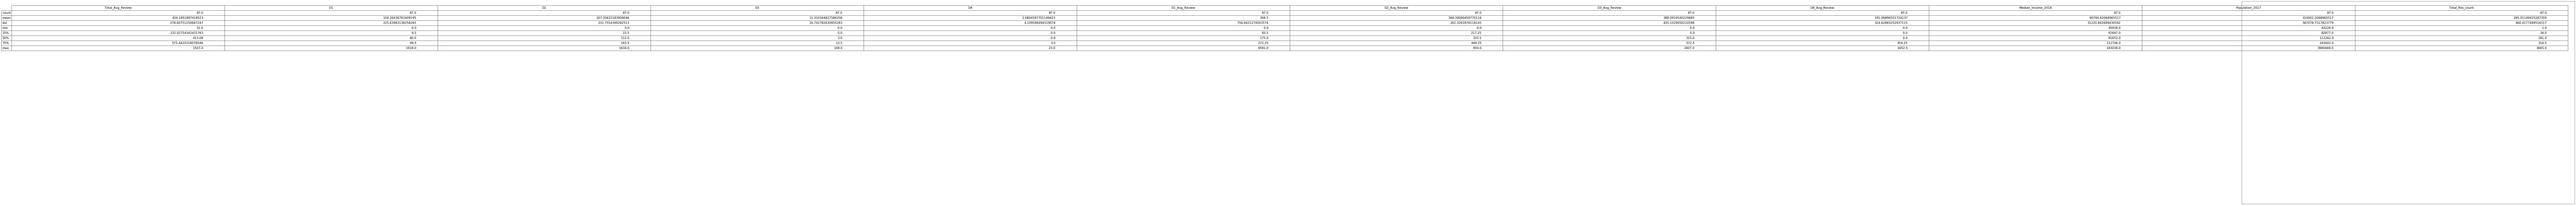

In [626]:

# import matplotlib.pyplot as plt
# from pandas.plotting import table

# desc = df_M.describe()

# # plt.figure(figsize=(16,200))
# # #create a subplot without frame
# # plot = plt.subplot(111, frame_on=False)

# # #remove axis
# # plot.xaxis.set_visible(False) 
# # plot.yaxis.set_visible(False)

# fig, ax = plt.subplots(figsize=(32, 20)) # set size frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# tabla = table(ax, df_M.describe(), loc='upper right', colWidths=[0.16]*len(df_M.columns))  # where df is your data frame
# tabla.auto_set_font_size(False) # Activate set fontsize manually
# tabla.set_fontsize(16) # if ++fontsize is necessary ++colWidths
# tabla.scale(4, 2.25) # change size table

# #create the table plot and position it in the upper left corner
# table(plot, desc,loc='upper right')

# #save the plot as a png file
# plt.savefig('desc_plot.png')

In [65]:
len(df_M_rmv[df_M_rmv.State =='CA'].City.unique())
# len(df_M_rmv.City.unique())

46

In [66]:
df_M.sort_values(by=['Median_Income_2018'], ascending=False)

#remove city less than 100 and more than 800
df_M_rmv = df_M[(df_M['Total_Res_count']>=50)&(df_M['Total_Res_count']<=1500)] 
# df_M_rmv = df_M.copy()
print(len(df_M_rmv))
df_M_rmv.sample(8)

63


,State,City,Total_Avg_Review,D1,D2,D3,D4,D1_Avg_Review,D2_Avg_Review,D3_Avg_Review,D4_Avg_Review,Median_Income_2018,Population_2017,Total_Res_count
71,CA,Union City,346.102041,42.0,56.0,0,0,145.5,346.5,0.0,0.0,123780.0,74568.0,98.0
67,CA,Stockton,148.558659,210.0,145.0,3,0,70.5,182.0,287.0,0.0,54297.0,311189.0,358.0
10,AZ,Tempe,117.709544,490.0,458.0,12,4,42.0,77.0,304.5,9.5,60330.0,192354.0,964.0
61,CA,San Ramon,241.750000,49.0,61.0,1,1,118.0,295.0,243.0,21.0,175974.0,75832.0,112.0
12,CA,Alhambra,510.532895,77.0,74.0,1,0,239.0,355.0,524.0,0.0,57432.0,84650.0,152.0
13,CA,Anaheim,584.373585,101.0,149.0,12,3,242.0,444.0,1501.0,938.0,76154.0,352018.0,265.0
83,WA,Redmond,244.600000,21.0,82.0,2,0,146.0,189.5,378.0,0.0,134844.0,67680.0,105.0
51,CA,Redondo Beach,424.703488,45.0,119.0,7,1,223.0,404.0,315.0,6.0,121690.0,67396.0,172.0


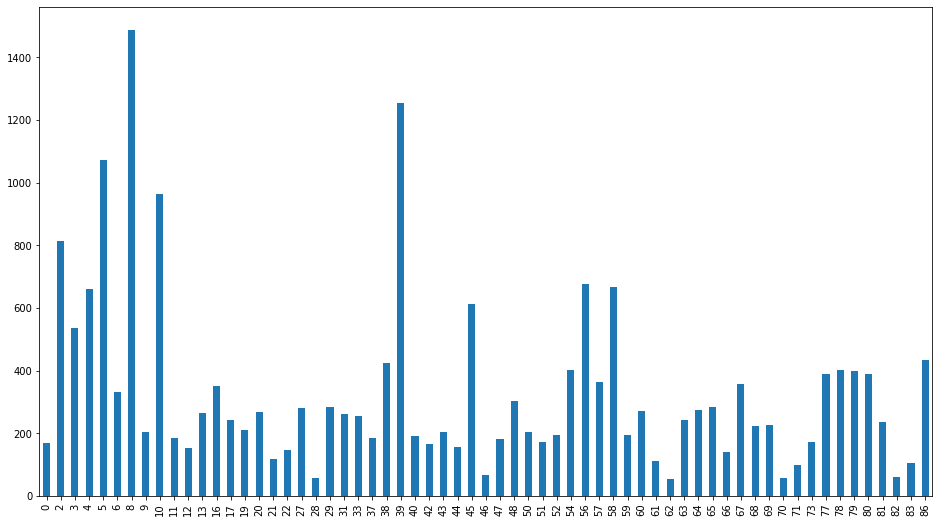

In [67]:
df_M_rmv.Total_Res_count.plot.bar(figsize = (16,9));


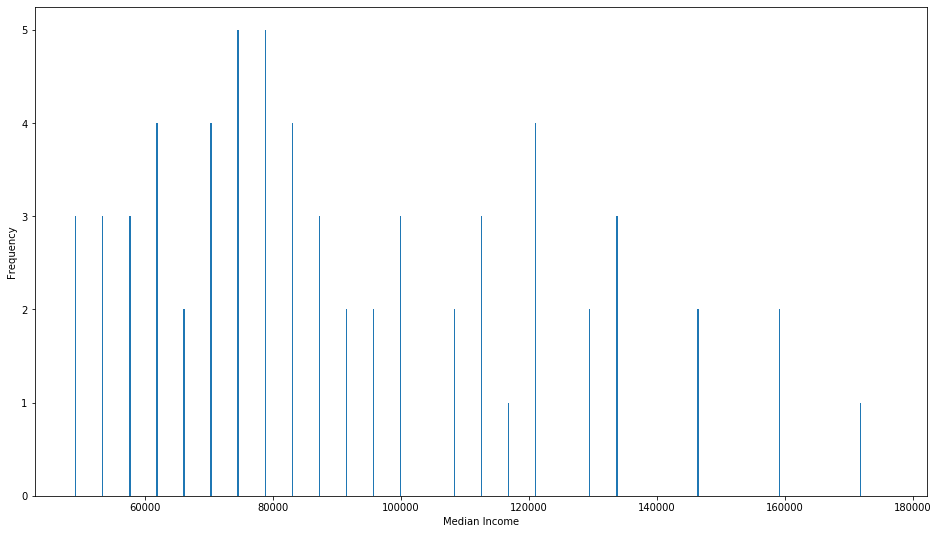

In [92]:
df_M_rmv.Median_Income_2018.plot.hist(width= 200 , bins = 30, figsize = (16,9));
plt.xlabel('Median Income');

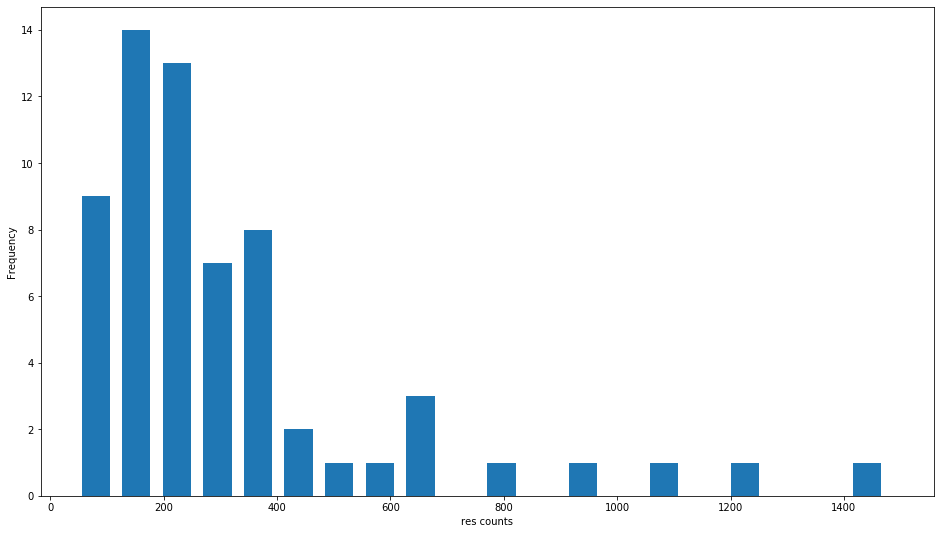

In [82]:
df_M_rmv.Total_Res_count.plot.hist(width =50 , bins = 20, figsize = (16,9));
plt.xlabel('res counts');

In [62]:
df_M_rmv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 86
Data columns (total 14 columns):
State                 63 non-null object
City                  63 non-null object
Total_Avg_Review      63 non-null float64
D1                    63 non-null float64
D2                    63 non-null float64
D3                    63 non-null uint8
D4                    63 non-null uint8
D1_Avg_Review         63 non-null float64
D2_Avg_Review         63 non-null float64
D3_Avg_Review         63 non-null float64
D4_Avg_Review         63 non-null float64
Median_Income_2018    63 non-null float64
Population_2017       63 non-null float64
Total_Res_count       63 non-null float64
dtypes: float64(10), object(2), uint8(2)
memory usage: 6.5+ KB


In [63]:
df_M_rmv.corr()

,Total_Avg_Review,D1,D2,D3,D4,D1_Avg_Review,D2_Avg_Review,D3_Avg_Review,D4_Avg_Review,Median_Income_2018,Population_2017,Total_Res_count
Total_Avg_Review,1.000000,-0.486069,0.025549,0.205429,0.162438,0.897168,0.955682,0.692317,0.476237,-0.010358,0.307583,-0.168579
D1,-0.486069,1.000000,0.663397,0.309878,0.303315,-0.496280,-0.550878,-0.337576,-0.122996,-0.335542,0.120326,0.846957
D2,0.025549,0.663397,1.000000,0.836066,0.791894,-0.104266,-0.127652,-0.102125,0.211997,-0.295584,0.659504,0.958600
D3,0.205429,0.309878,0.836066,1.000000,0.964629,0.065365,0.037786,-0.019600,0.273929,-0.188196,0.642329,0.726463
D4,0.162438,0.303315,0.791894,0.964629,1.000000,0.051904,0.005169,-0.016738,0.255999,-0.188522,0.587888,0.694747
D1_Avg_Review,0.897168,-0.496280,-0.104266,0.065365,0.051904,1.000000,0.904167,0.581349,0.291892,-0.079426,0.192536,-0.263945
D2_Avg_Review,0.955682,-0.550878,-0.127652,0.037786,0.005169,0.904167,1.000000,0.652761,0.359619,0.061412,0.172890,-0.303592
D3_Avg_Review,0.692317,-0.337576,-0.102125,-0.019600,-0.016738,0.581349,0.652761,1.000000,0.364199,-0.024921,0.070903,-0.204044
D4_Avg_Review,0.476237,-0.122996,0.211997,0.273929,0.255999,0.291892,0.359619,0.364199,1.000000,-0.126601,0.251001,0.102257
Median_Income_2018,-0.010358,-0.335542,-0.295584,-0.188196,-0.188522,-0.079426,0.061412,-0.024921,-0.126601,1.000000,-0.344289,-0.336203


In [64]:
df_M_rmv.corr()['D1'].sort_values(ascending=False)

D1                    1.000000
Total_Res_count       0.846957
D2                    0.663397
D3                    0.309878
D4                    0.303315
Population_2017       0.120326
D4_Avg_Review        -0.122996
Median_Income_2018   -0.335542
D3_Avg_Review        -0.337576
Total_Avg_Review     -0.486069
D1_Avg_Review        -0.496280
D2_Avg_Review        -0.550878
Name: D1, dtype: float64

In [65]:
df_M_rmv.describe()

,Total_Avg_Review,D1,D2,D3,D4,D1_Avg_Review,D2_Avg_Review,D3_Avg_Review,D4_Avg_Review,Median_Income_2018,Population_2017,Total_Res_count
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,6.300000e+01,63.000000
mean,414.772409,112.269841,202.365079,14.031746,2.619048,196.753968,332.492063,511.809524,259.031746,93672.047619,3.670452e+05,331.285714
std,217.297788,117.146201,172.429818,20.526119,4.345664,126.717583,159.991922,433.195603,357.760686,31044.790661,6.292936e+05,282.439684
min,71.797619,6.000000,40.000000,0.000000,0.000000,27.000000,33.500000,0.000000,0.000000,49024.000000,6.472900e+04,55.000000
25%,252.439831,50.000000,102.000000,2.000000,0.000000,107.000000,233.250000,266.750000,0.000000,70911.500000,8.498250e+04,171.500000
50%,415.937173,82.000000,159.000000,7.000000,1.000000,182.000000,342.500000,429.500000,32.000000,85527.000000,1.396290e+05,243.000000
75%,556.398926,106.000000,269.000000,16.500000,3.000000,255.250000,446.500000,615.500000,440.500000,114224.000000,2.968865e+05,390.500000
max,933.631579,586.000000,935.000000,108.000000,23.000000,651.500000,766.000000,2407.000000,1652.500000,175974.000000,3.990469e+06,1487.000000


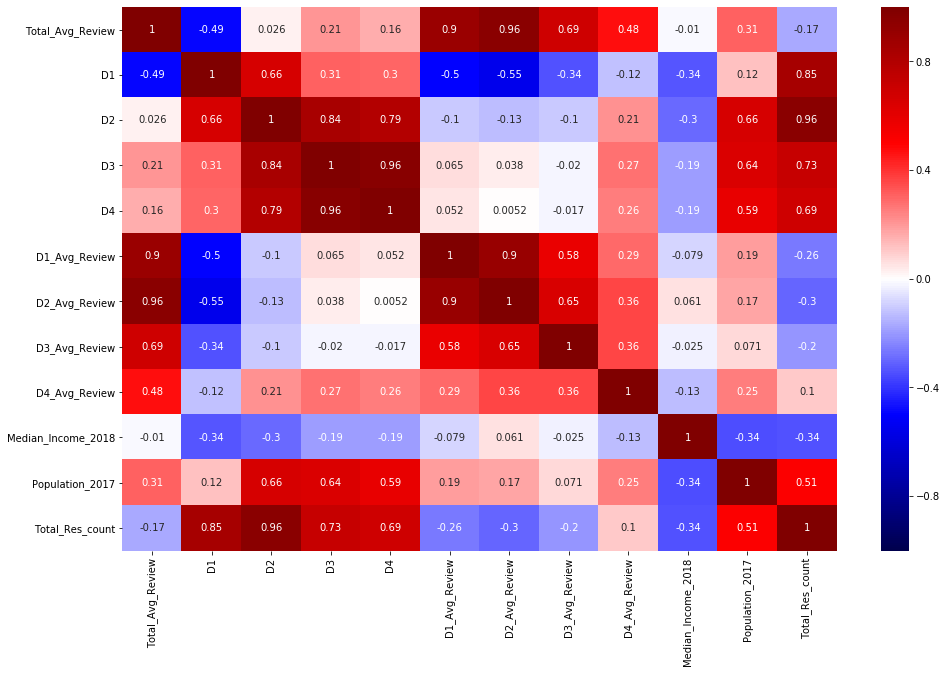

In [601]:
plt.figure(figsize=(16,10))
sns.heatmap(df_M_rmv.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1); #always define vmin and vmax


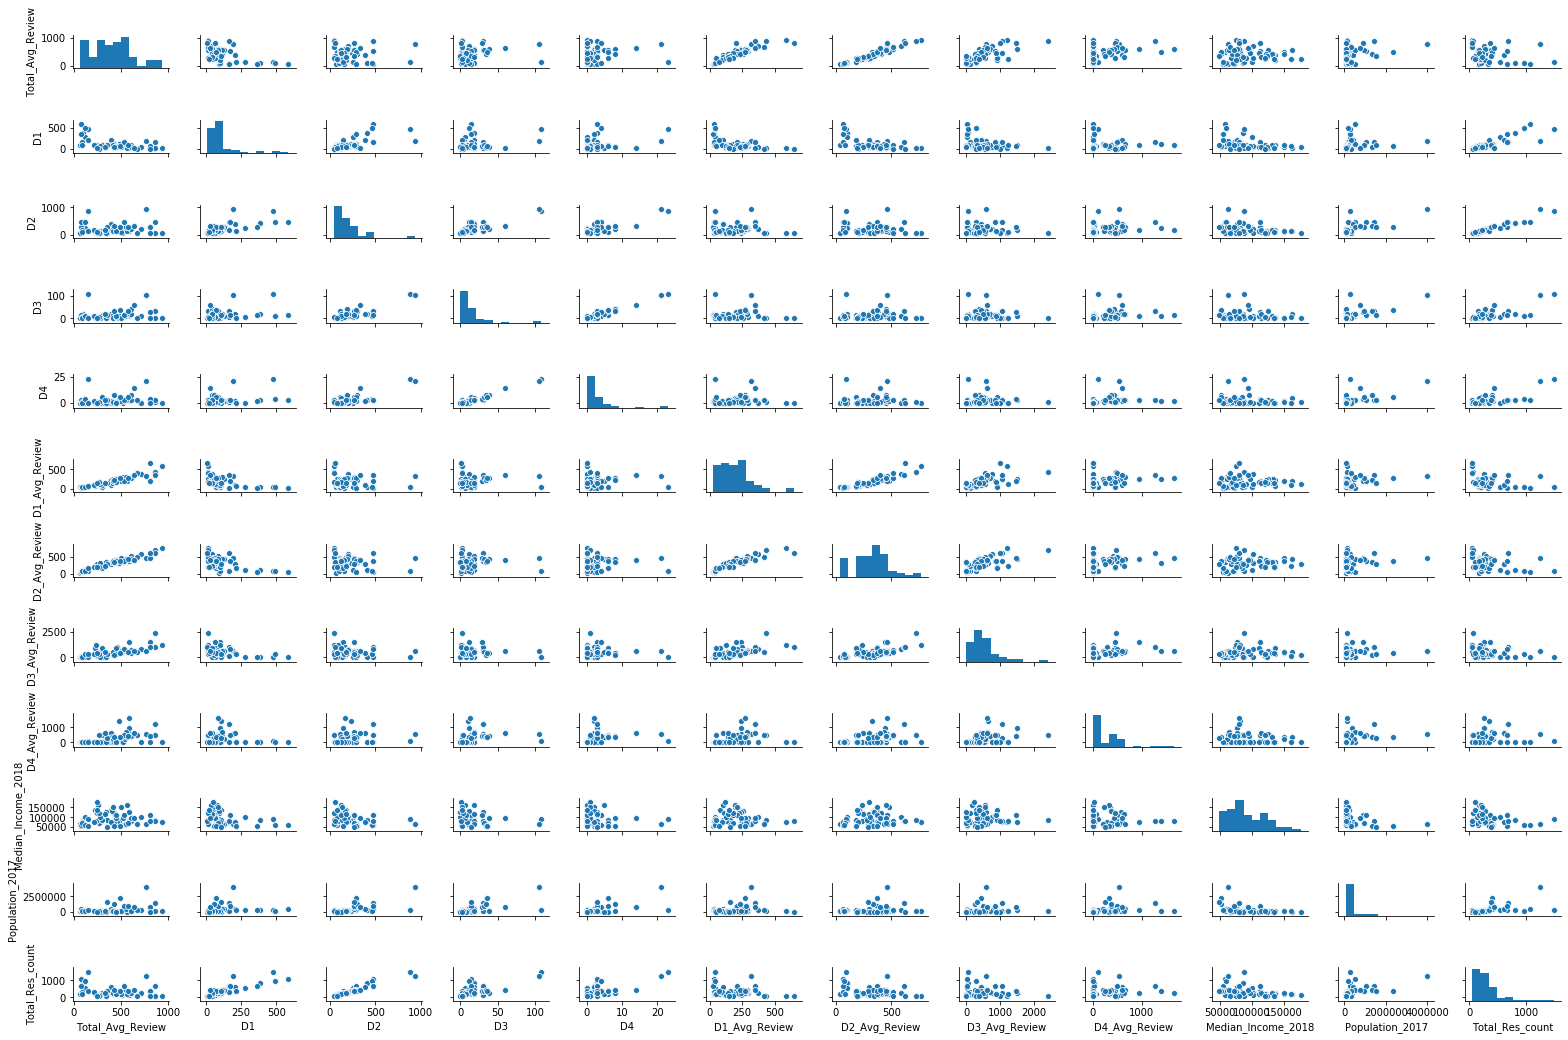

In [67]:
sns.pairplot(df_M_rmv, height=1.2, aspect=1.5);

# Initial Look

In [94]:
def OLS_vanilla(X_list, y_list, df, standardize = True):
    
    X,y = df[X_list], df[y_list]
    
    if standardize:
        std = StandardScaler()
        std.fit(X.values)
        X = std.transform(X.values)     
    
    # Create your model  #setting up formula
    model = sm.OLS(y, sm.add_constant(X))
    # Fit your model to your training set
    fit = model.fit()
    # Print summary statistics of the model's performance
    print(fit.summary())

    plt.figure(figsize=(12,8))
    plt.scatter(fit.predict(), fit.resid);

## OLS with Statsmodel

### Try 1  - predict amount of 1 dollar sign resturants per city 


                            OLS Regression Results                            
Dep. Variable:                     D1   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     6.686
Date:                Sat, 12 Oct 2019   Prob (F-statistic):           2.25e-05
Time:                        21:58:53   Log-Likelihood:                -371.97
No. Observations:                  63   AIC:                             757.9
Df Residuals:                      56   BIC:                             772.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.2698     11.854      9.471      0.0

/Users/vsu/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


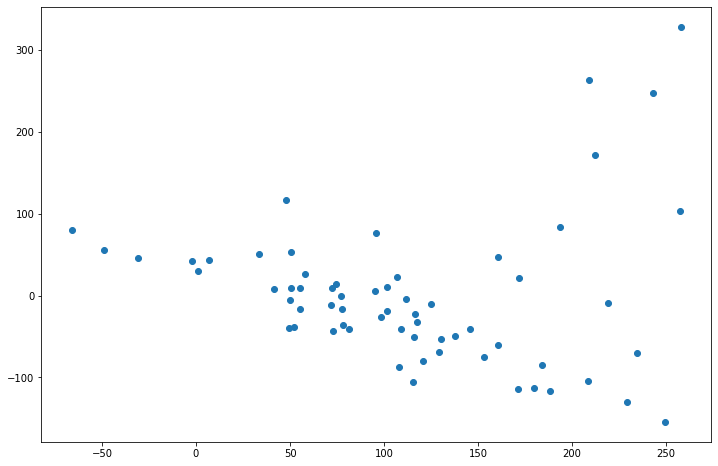

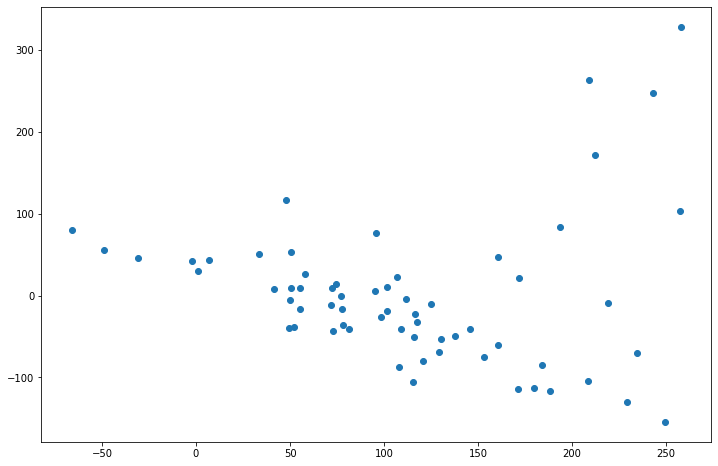

In [95]:
X_selected = ['D1_Avg_Review','D2_Avg_Review','D3_Avg_Review','D4_Avg_Review','Median_Income_2018', 'Population_2017']
y_selected = ['D1']


OLS_vanilla(X_selected, y_selected, df_M_rmv, standardize = True)
OLS_vanilla(X_selected,y_selected,df_M_rmv, standardize = False)

## Try2

                            OLS Regression Results                            
Dep. Variable:                     D1   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     138.6
Date:                Sat, 12 Oct 2019   Prob (F-statistic):           5.68e-29
Time:                        21:59:23   Log-Likelihood:                -314.75
No. Observations:                  63   AIC:                             639.5
Df Residuals:                      58   BIC:                             650.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.2698      4.697     23.904      0.0

/Users/vsu/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


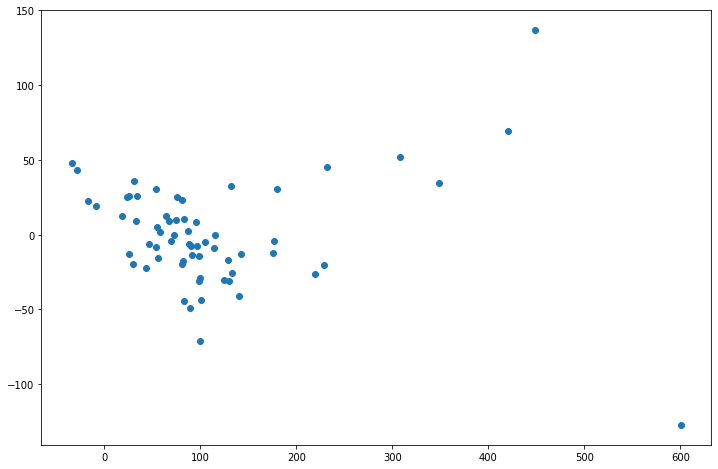

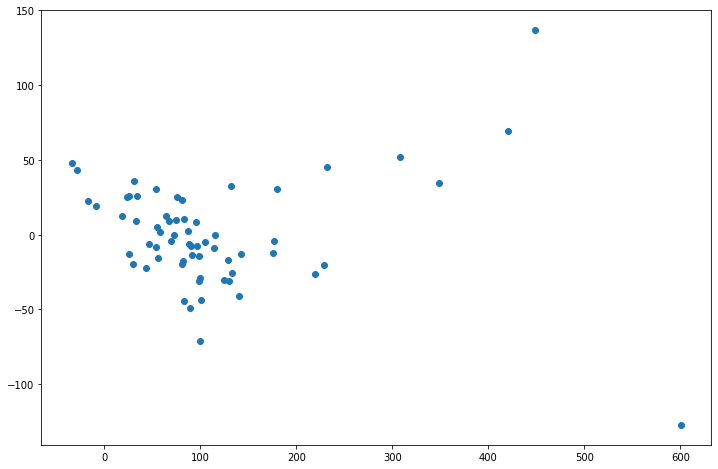

In [96]:
X_selected = ['Total_Avg_Review','Total_Res_count','Median_Income_2018', 'Population_2017']
y_selected = ['D1']


OLS_vanilla(X_selected, y_selected, df_M_rmv, standardize = True)
OLS_vanilla(X_selected,y_selected,df_M_rmv, standardize = False)

## Lasso

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

(array([21.,  2.,  7.,  3.,  2.,  0.,  1.,  0.,  0.,  1.]),
 array([-0.71081761, -0.25826519,  0.19428722,  0.64683964,  1.09939205,
         1.55194447,  2.00449688,  2.4570493 ,  2.90960171,  3.36215413,
         3.81470654]),
 <a list of 10 Patch objects>)

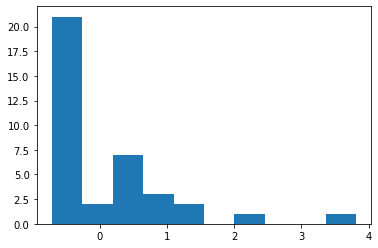

In [97]:
df_M_valid = df_M_rmv.copy()



X_selected = ['D1_Avg_Review','D2_Avg_Review','D3_Avg_Review','D4_Avg_Review',
              'Total_Res_count','Population_2017','Median_Income_2018']
y_selected = ['D1']


#break into 20 20 80 for test, val and train dataset

X, y = df_M_valid[X_selected], df_M_valid[y_selected]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=50)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=50)


std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)
plt.hist(X_tr[:,3])

## Lasso model to get rid of high features

In [98]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [99]:
def fit_model(estimator, fold, X_columns, y_columns, df, standardize = True, RandomState = 24):
    """
    split dataset into 80/20/20 >> train, test, val
    cross valid function. Will output graph, best fit alpha, r2score and Mean abs error
    estimator - RidgeCV or LassoCV
    fold = how many fold will like to test
    X = train X
    y = predict y
    df = dataframe
    RandomState = randonnumber
    """
    
    X, y = df[X_columns], df[y_columns]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RandomState )
#     X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=RandomState )

    if standardize :
        std = StandardScaler()
        std.fit(X_train.values)
        X_tr = std.transform(X_train.values)
        X_te = std.transform(X_test.values)
    else:
        X_tr = X_train.values
        X_te = X_test.values

    
    alphavec = 10**np.linspace(-2,2,200)

    fit_model = estimator(alphas = alphavec, cv=fold)
    fit_model.fit(X_tr, y_train)
    
    print('Estimator: {} with {} folds'.format(estimator,fold))
    if estimator != RidgeCV:
        for value, coef in zip(X_train, fit_model.coef_):
            print(value ,':', coef)
    else:
        for value, coef in zip(X_train, fit_model.coef_[0]):
            print(value ,':', coef)
    
    test_set_pred = fit_model.predict(X_te)
    
    
    plt.scatter(test_set_pred, y_test, alpha=.9, c = 'orange')
    plt.plot(np.linspace(0,800,1000), np.linspace(0,800,1000), c = 'blue')
    plt.xlabel('test_set_pred')
    plt.ylabel('y_test')
    
    print('best fit alpha:',fit_model.alpha_)
    
#     #r-squared
    print('r2 score:',r2_score(y_test, test_set_pred)) 
    if estimator != RidgeCV:
        
        print('Mean abs error:', mae(y_test['D1'], test_set_pred))
    else:
        print('Mean abs error:', mae(y_test, test_set_pred))
    
    

/Users/vsu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Estimator: <class 'sklearn.linear_model.coordinate_descent.LassoCV'> with 5 folds
D1_Avg_Review : -28.687937110467747
D2_Avg_Review : -5.269170542526718
D3_Avg_Review : 0.0
D4_Avg_Review : 0.0
Population_2017 : 9.739688019703337
Median_Income_2018 : -21.682733699679694
best fit alpha: 5.672426068491977
r2 score: 0.17823936850914024
Mean abs error: 90.24369821452781


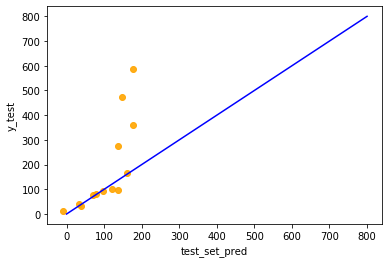

In [100]:
df_M_valid = df_M_rmv.copy()

X_selected = ['D1_Avg_Review','D2_Avg_Review','D3_Avg_Review','D4_Avg_Review',
              'Population_2017','Median_Income_2018']
y_selected = ['D1']

# Lasso
fit_model(LassoCV, 5, X_selected, y_selected,df_M_valid, standardize = True, RandomState = 55)

/Users/vsu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Estimator: <class 'sklearn.linear_model.coordinate_descent.LassoCV'> with 5 folds
D1_Avg_Review : -11.851352044962587
D2_Avg_Review : -4.169994966442429
D3_Avg_Review : 4.21231677345329
D4_Avg_Review : -12.728362792399826
Total_Res_count : 96.75052609110864
Population_2017 : -48.41614803731136
Median_Income_2018 : -14.251261126075578
best fit alpha: 0.23272024789604084
r2 score: 0.8740877601101031
Mean abs error: 42.5662471677963


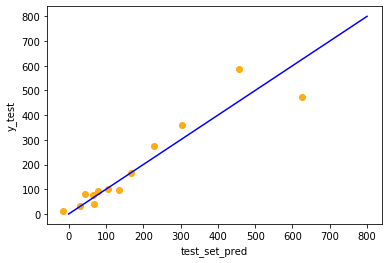

In [101]:
df_M_valid = df_M_rmv.copy()

X_selected = ['D1_Avg_Review','D2_Avg_Review','D3_Avg_Review','D4_Avg_Review',
              'Total_Res_count','Population_2017','Median_Income_2018']
y_selected = ['D1']

# Lasso
fit_model(LassoCV, 5, X_selected, y_selected,df_M_valid, standardize = True, RandomState = 55)

Estimator: <class 'sklearn.linear_model.ridge.RidgeCV'> with 5 folds
D1_Avg_Review : -12.013884092548116
D2_Avg_Review : -4.585470643316634
D3_Avg_Review : 4.8613894585480395
D4_Avg_Review : -13.009655508171726
Total_Res_count : 96.5208351096848
Population_2017 : -48.26405322838536
Median_Income_2018 : -14.514057642131014
best fit alpha: 0.16831803533309567
r2 score: 0.8744169901286137
Mean abs error: D1    42.87423
dtype: float64


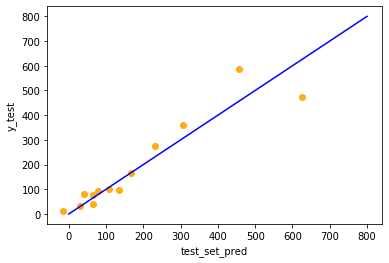

In [102]:
#Ridge model
fit_model(RidgeCV, 5, X_selected, y_selected,df_M_valid, standardize = True, RandomState = 55)


## Remove some features - try1

/Users/vsu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Estimator: <class 'sklearn.linear_model.coordinate_descent.LassoCV'> with 5 folds
D2_Avg_Review : -16.50831838279574
Total_Res_count : 95.62914144690116
Population_2017 : -50.649732334101024
Median_Income_2018 : -12.217357834930427
best fit alpha: 0.01
r2 score: 0.8749308476534086
Mean abs error: 40.81273578086639


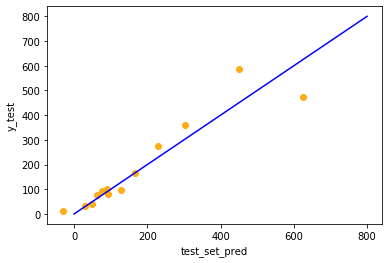

In [104]:
X_selected = ['D2_Avg_Review','Total_Res_count','Population_2017','Median_Income_2018']
y_selected = ['D1']
fit_model(LassoCV, 5, X_selected, y_selected,df_M_valid, standardize = True, RandomState = 55)

                            OLS Regression Results                            
Dep. Variable:                     D1   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     123.9
Date:                Sat, 12 Oct 2019   Prob (F-statistic):           1.05e-27
Time:                        22:00:33   Log-Likelihood:                -317.93
No. Observations:                  63   AIC:                             645.9
Df Residuals:                      58   BIC:                             656.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.2698      4.940     22.727      0.0

/Users/vsu/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


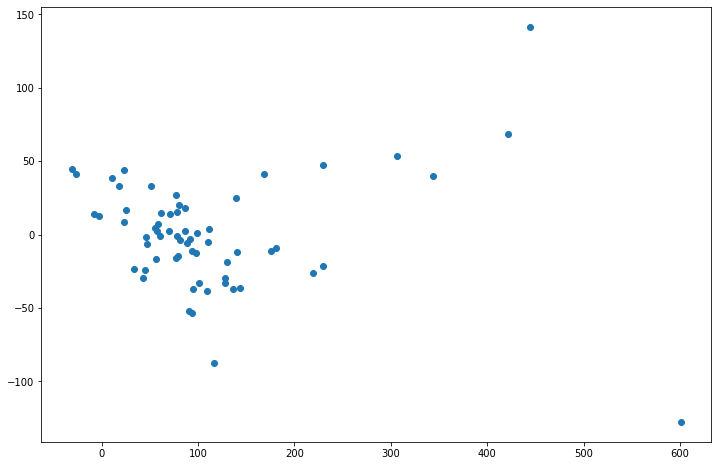

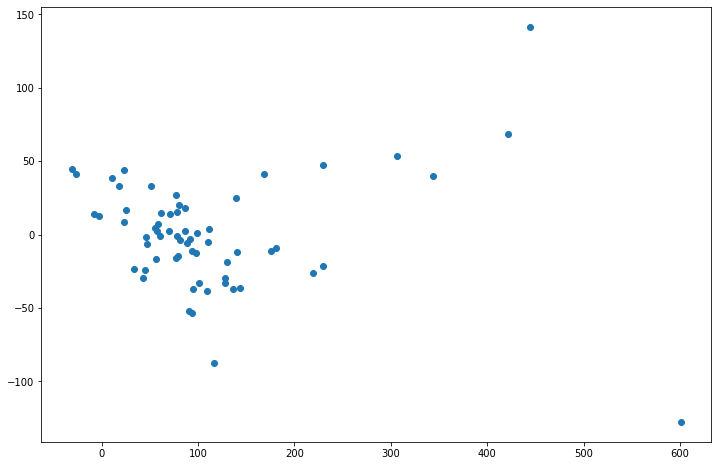

In [105]:
OLS_vanilla(X_selected,y_selected,df_M_valid, standardize = True)
OLS_vanilla(X_selected,y_selected,df_M_valid, standardize = False)

## Remove some features - Try 2

/Users/vsu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Estimator: <class 'sklearn.linear_model.coordinate_descent.LassoCV'> with 5 folds
Total_Res_count : 97.73761399203529
Population_2017 : -47.44287483904595
D2_Avg_Review : -17.012696257101762
best fit alpha: 0.01
r2 score: 0.8584403545540591
Mean abs error: 44.03138191880977


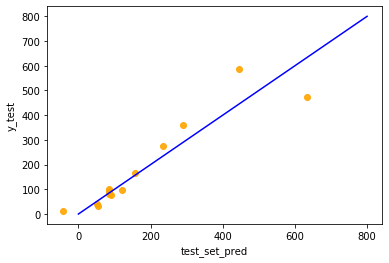

In [106]:
X_selected = ['Total_Res_count','Population_2017','D2_Avg_Review']
y_selected = ['D1']
fit_model(LassoCV, 5, X_selected, y_selected,df_M_valid, standardize = True, RandomState = 55)

                            OLS Regression Results                            
Dep. Variable:                     D1   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     143.3
Date:                Sat, 12 Oct 2019   Prob (F-statistic):           4.76e-27
Time:                        22:00:42   Log-Likelihood:                -322.38
No. Observations:                  63   AIC:                             652.8
Df Residuals:                      59   BIC:                             661.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.2698      5.257     21.358      0.0

/Users/vsu/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


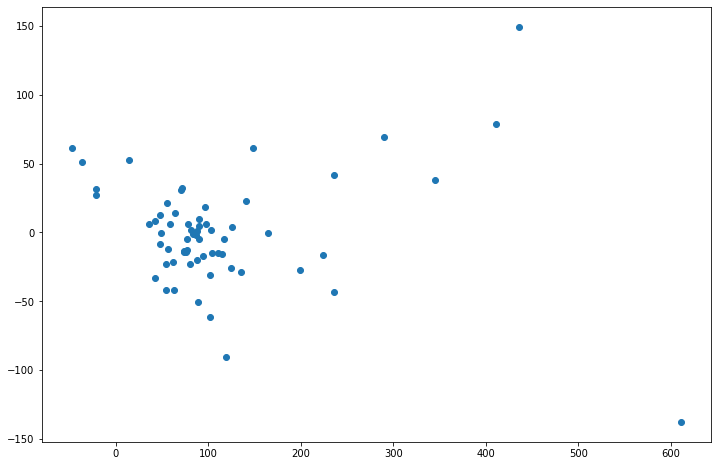

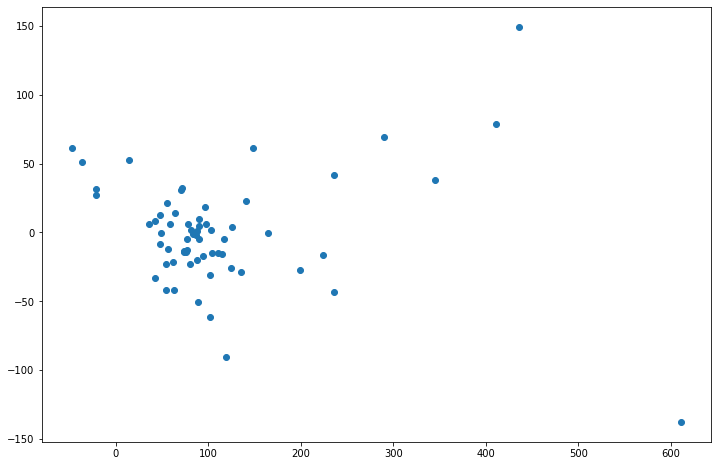

In [107]:
OLS_vanilla(X_selected,y_selected,df_M_valid, standardize = True)
OLS_vanilla(X_selected,y_selected,df_M_valid, standardize = False)

## Remove some features - Try 3

/Users/vsu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Estimator: <class 'sklearn.linear_model.coordinate_descent.LassoCV'> with 5 folds
Total_Avg_Review : -21.775764959043933
Total_Res_count : 98.41703454673612
Population_2017 : -43.54232484848855
best fit alpha: 0.01
r2 score: 0.8615351340903472
Mean abs error: 42.56715842902466


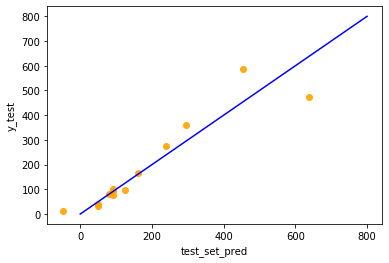

In [108]:
X_selected = ['Total_Avg_Review', 'Total_Res_count','Population_2017']
y_selected = ['D1']
fit_model(LassoCV, 5, X_selected, y_selected,df_M_valid, standardize = True, RandomState = 55)

                            OLS Regression Results                            
Dep. Variable:                     D1   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     157.4
Date:                Sat, 12 Oct 2019   Prob (F-statistic):           4.09e-28
Time:                        22:00:46   Log-Likelihood:                -319.76
No. Observations:                  63   AIC:                             647.5
Df Residuals:                      59   BIC:                             656.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.2698      5.042     22.267      0.0

/Users/vsu/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


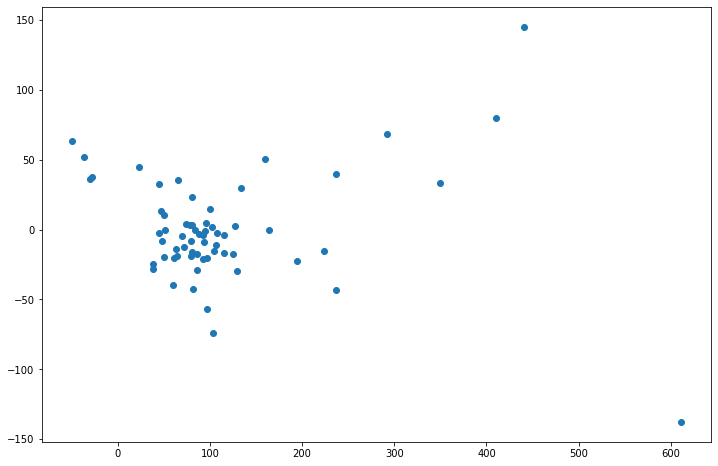

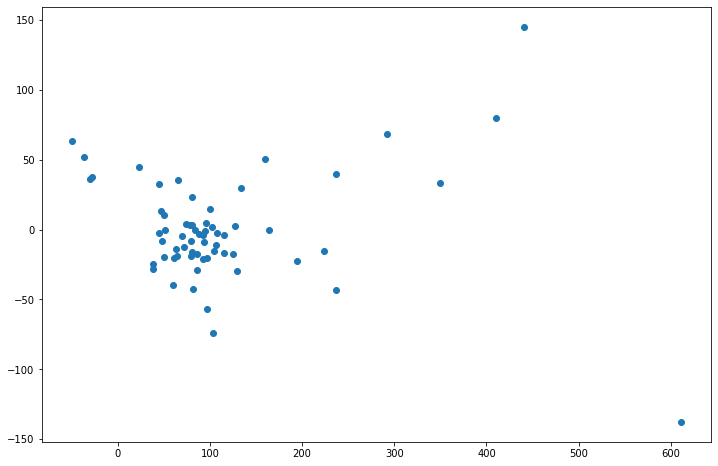

In [109]:
OLS_vanilla(X_selected,y_selected,df_M_valid, standardize = True)
OLS_vanilla(X_selected,y_selected,df_M_valid, standardize = False)

## Remove some features - Try 4 >> FINAL PICK

/Users/vsu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Estimator: <class 'sklearn.linear_model.coordinate_descent.LassoCV'> with 5 folds
Total_Res_count : 96.14280015410112
Population_2017 : -46.71496756574022
Median_Income_2018 : -12.447209906573702
Total_Avg_Review : -21.494795809447155
best fit alpha: 0.01
r2 score: 0.8784052113918601
Mean abs error: 39.56756955580089


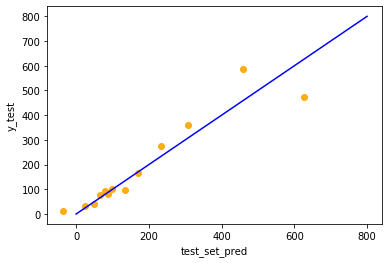

In [110]:
X_selected = ['Total_Res_count','Population_2017','Median_Income_2018','Total_Avg_Review']
y_selected = ['D1']
fit_model(LassoCV, 5, X_selected, y_selected,df_M_valid, standardize = True, RandomState = 55)

                            OLS Regression Results                            
Dep. Variable:                     D1   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     138.6
Date:                Sat, 12 Oct 2019   Prob (F-statistic):           5.68e-29
Time:                        22:00:51   Log-Likelihood:                -314.75
No. Observations:                  63   AIC:                             639.5
Df Residuals:                      58   BIC:                             650.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.2698      4.697     23.904      0.0

/Users/vsu/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


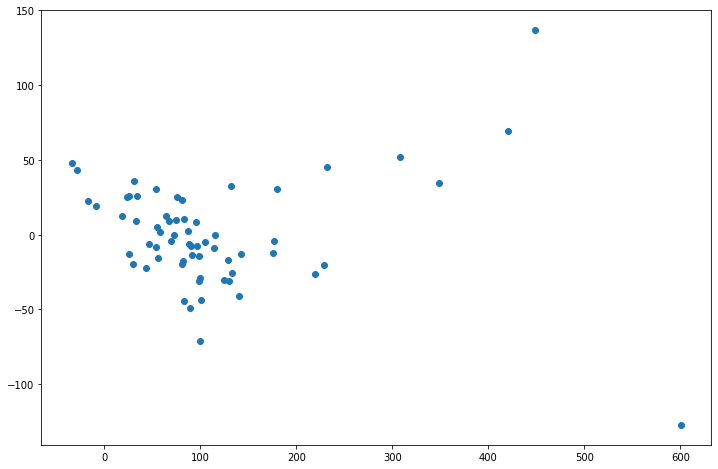

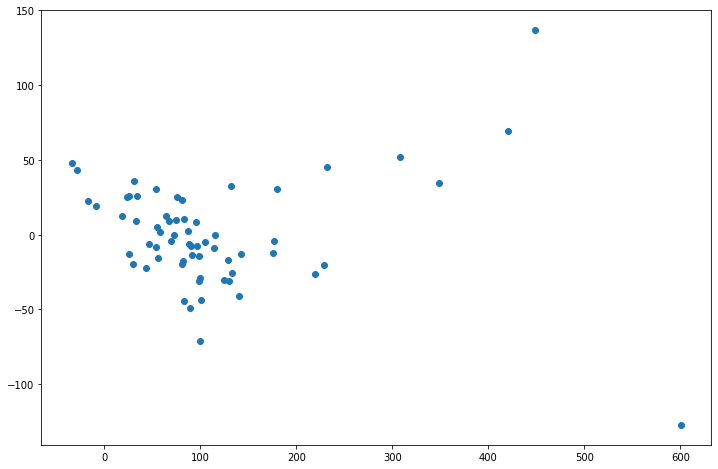

In [111]:
OLS_vanilla(X_selected,y_selected,df_M_valid, standardize = True)
OLS_vanilla(X_selected,y_selected,df_M_valid, standardize = False)

## Finding Regression Model

In [112]:
# hold out 20% of the data for final testing


X_selected = ['Total_Res_count','Population_2017','Median_Income_2018','Total_Avg_Review']
y_selected = ['D1']


X, y = df_M_rmv[X_selected], df_M_rmv[y_selected]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=20)




In [113]:
#set up the 3 models we're choosing from:

lm = LinearRegression()


#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values) #fit >> finding beta value, transform >> normalized/ standardized the value
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()
# lm_poly = Lasso() or ridge()

In [114]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.848
Ridge Regression val R^2: 0.807
Degree 2 polynomial regression val R^2: 0.431


In [117]:
lm.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

lm_reg.fit(X,y)
print(f'Ridge Regression test R^2: {lm.score(X_test, y_test):.3f}')

lm_poly.fit(X,y)
print(f'Degree 2 polynomial regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.921
Ridge Regression test R^2: 0.921
Degree 2 polynomial regression test R^2: 0.921


In [118]:
# USING LASSO~~~~

# Features! Total Restuarant, Population, Income, Total Avg Reviews

In [119]:
def split_and_validate(X_selected, y_selected, df, estimator, fold):
    '''
    For a set of features and target X, y, perform a 80/20/ train/test split,
    standardize data before fit
    fit and cross validate a regression model, and report results
    '''
    from sklearn.model_selection import GridSearchCV
    param_grid ={'alpha': np.linspace(0,1,10)}
    
    my_model = estimator()
    my_grid_search = GridSearchCV(my_model, param_grid, cv= fold, n_jobs=-1)

    #break into 20 20 80 for test, val and train dataset

    X, y = df[X_selected], df[y_selected]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=50)
#     X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=50)

    # calcualting mean and std for each columns
    
    std_ls = []
    mean_ls = []
    for i in range(0, X_train.shape[1]):
        
        std = X_train.iloc[:,i].std()
        mean = X_train.iloc[:,i].mean()
        std_ls.append(std)
        mean_ls.append(mean)
    

    
    
    std = StandardScaler()
    std.fit(X_train.values)
    X_tr = std.transform(X_train.values)
    X_te = std.transform(X_test.values)
    
    
    # fit regression to training data
    my_grid_search.fit(X_tr, y_train)

    
    
    # score fit model on validation data
    val_score = my_grid_search.score(X_te, y_test)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    counter = 0
    for feature, coef in zip(X.columns, my_grid_search.best_estimator_.coef_):
        
        print('{} : {} >> {}'.format(feature, coef, coef/std_ls[0]))
        counter +=1
        
    test_set_pred = my_grid_search.predict(X_te)   
    plt.scatter(test_set_pred, y_test, alpha=.9, c = 'orange')
    plt.plot(np.linspace(0,500,1000), np.linspace(0,500,1000)) 

In [120]:
X_selected = ['Total_Res_count','Population_2017','Median_Income_2018','Total_Avg_Review']
y_selected = ['D1']


Validation R^2 score was: 0.9207542467825832
Feature coefficient results: 

Total_Res_count : 89.14826045314489 >> 0.3540757438437085
Population_2017 : -20.875107613133466 >> -0.08291097569786565
Median_Income_2018 : -15.021466475202494 >> -0.05966170162822312
Total_Avg_Review : -25.211535814489856 >> -0.10013423987840563


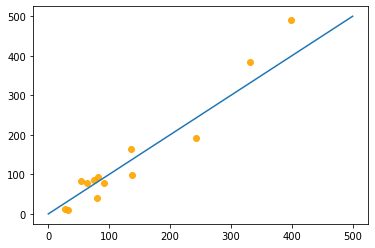

In [121]:
split_and_validate(X_selected, y_selected, df_M_valid, Lasso, 5)

## Feature Engineer

In [122]:
df_play_1 = df_M_valid.copy()

In [123]:
df_play_1.head(2)

,State,City,Total_Avg_Review,D1,D2,D3,D4,D1_Avg_Review,D2_Avg_Review,D3_Avg_Review,D4_Avg_Review,Median_Income_2018,Population_2017,Total_Res_count
0,AZ,Avondale,71.797619,95.0,72.0,1,0,34.0,33.5,11.0,9.0,63242.0,85828.0,168.0
2,AZ,Chandler,102.720245,383.0,411.0,18,3,35.0,100.0,50.0,28.0,85527.0,257153.0,815.0


In [124]:
df_play_1 = df_play_1.drop(columns = ['D2','D3','D4','D1_Avg_Review','D2_Avg_Review','D3_Avg_Review','D4_Avg_Review'])

In [125]:
df_play_1['Res_count_sq'] = df_play_1['Total_Res_count']**2
df_play_1.head(2)

,State,City,Total_Avg_Review,D1,Median_Income_2018,Population_2017,Total_Res_count,Res_count_sq
0,AZ,Avondale,71.797619,95.0,63242.0,85828.0,168.0,28224.0
2,AZ,Chandler,102.720245,383.0,85527.0,257153.0,815.0,664225.0



Validation R^2 score was: 0.7150574307340319
Feature coefficient results: 

Res_count_sq : 75.91485268115996 >> 0.0002185588909800461
Population_2017 : -4.38487361872791 >> -1.2624052887540821e-05
Median_Income_2018 : -19.28420829633801 >> -5.5519243334075845e-05
Total_Avg_Review : -34.01667040841376 >> -9.793400759824887e-05


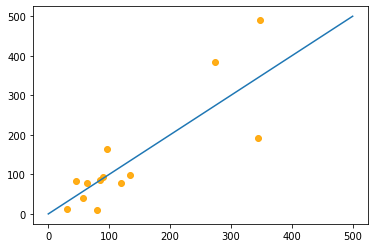

In [126]:
# no good
X_selected = ['Res_count_sq','Population_2017','Median_Income_2018','Total_Avg_Review']
y_selected = ['D1']
split_and_validate(X_selected, y_selected, df_play_1, Lasso, 5)

In [127]:
df_play_1['Income_sq'] = df_play_1['Median_Income_2018']**2


Validation R^2 score was: 0.9152315942484714
Feature coefficient results: 

Total_Res_count : 89.06252872275176 >> 0.3537352377468351
Population_2017 : -19.0719625389753 >> -0.07574931118365752
Income_sq : -12.476021149694848 >> -0.04955179659517638
Total_Avg_Review : -26.018128699535595 >> -0.10333783548756188


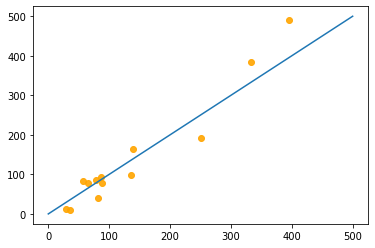

In [128]:
X_selected = ['Total_Res_count','Population_2017','Income_sq','Total_Avg_Review']
y_selected = ['D1']
split_and_validate(X_selected, y_selected, df_play_1, Lasso, 5)

In [129]:
df_play_1['Review_sq'] = df_play_1['Total_Avg_Review']**2


Validation R^2 score was: 0.9054977235877816
Feature coefficient results: 

Total_Res_count : 92.91444894316152 >> 0.3690341511562003
Population_2017 : -22.485929355620137 >> -0.089308777559298
Income_sq : -14.026094923179985 >> -0.05570832193363589
Review_sq : -19.275476534275487 >> -0.07655762049785209


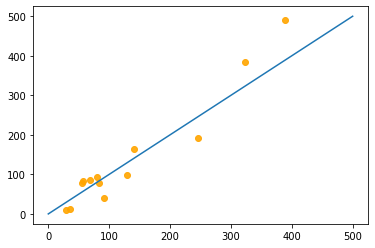

In [130]:
X_selected = ['Total_Res_count','Population_2017','Income_sq','Review_sq']
y_selected = ['D1']
split_and_validate(X_selected, y_selected, df_play_1, Lasso, 5)

In [131]:
df_play_2 = df_play_1.copy()
# df_play_2 = df_play_2.drop(columns = ['D2','D3','D4','D1_Avg_Review','D2_Avg_Review','D3_Avg_Review',
#                                       'D4_Avg_Review'])

In [132]:
df_play_2['Res_Div_pop'] = df_play_2['Total_Res_count']/df_play_2['Population_2017']



Validation R^2 score was: 0.44116076414790983
Feature coefficient results: 

Res_Div_pop : 35.211318755320505 >> 33840.47673944791
Median_Income_2018 : -37.261954019036565 >> -35811.27696494044
Total_Avg_Review : -39.91111716004162 >> -38357.30326617456


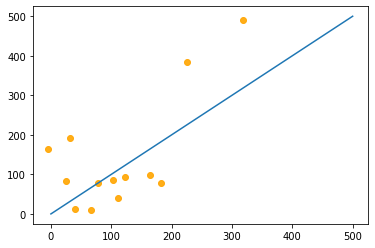

In [133]:
X_selected = ['Res_Div_pop','Median_Income_2018','Total_Avg_Review']
y_selected = ['D1']
split_and_validate(X_selected, y_selected, df_play_2, Lasso, 5)


Validation R^2 score was: 0.6640018783068516
Feature coefficient results: 

Res_Div_pop : 46.617362941217884 >> 44802.46244762739
Median_Income_2018 : -30.94062088274268 >> -29736.04506443881
Total_Avg_Review : -37.99326023294891 >> -36514.11207013158
Population_2017 : 23.65211679135182 >> 22731.295969864936


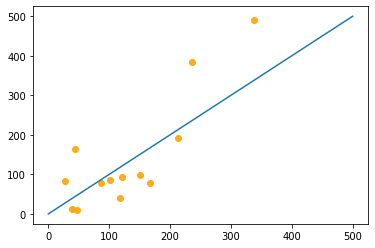

In [134]:
X_selected = ['Res_Div_pop','Median_Income_2018','Total_Avg_Review','Population_2017']
y_selected = ['D1']
split_and_validate(X_selected, y_selected, df_play_2, Lasso, 5)

In [135]:
def OLS_vanilla(X_list, y_list, df, standardize = True, plot = False):
    
    X,y = df[X_list], df[y_list]
    
    if standardize:
        std = StandardScaler()
        std.fit(X.values)
        X = std.transform(X.values)     
    
    # Create your model 
    model = sm.OLS(y, sm.add_constant(X))
    # Fit your model to your training set
    fit = model.fit()
    # Print summary statistics of the model's performance
    print(fit.summary())
    if plot == True:
        
        plt.figure(figsize=(12,8))
        plt.scatter(fit.predict(), fit.resid);

In [136]:
X_selected = ['Total_Res_count','Population_2017','Median_Income_2018','Total_Avg_Review']
y_selected = ['D1']


Validation R^2 score was: 0.9207542467825832
Feature coefficient results: 

Total_Res_count : 89.14826045314489 >> 0.3540757438437085
Population_2017 : -20.875107613133466 >> -0.08291097569786565
Median_Income_2018 : -15.021466475202494 >> -0.05966170162822312
Total_Avg_Review : -25.211535814489856 >> -0.10013423987840563


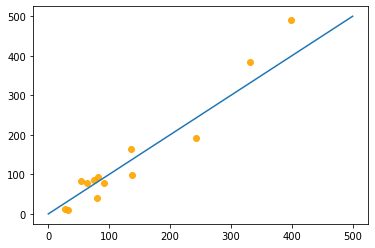

In [137]:
split_and_validate(X_selected, y_selected, df_M_valid, Lasso, 5)

                            OLS Regression Results                            
Dep. Variable:                     D1   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     138.6
Date:                Sat, 12 Oct 2019   Prob (F-statistic):           5.68e-29
Time:                        22:01:57   Log-Likelihood:                -314.75
No. Observations:                  63   AIC:                             639.5
Df Residuals:                      58   BIC:                             650.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        112.2698      4.697     23.904      0.0

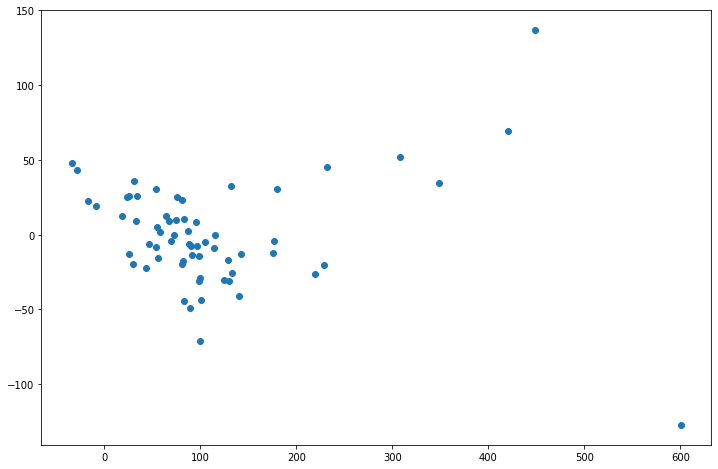

In [138]:
OLS_vanilla(X_selected,y_selected,df_M_valid,standardize = True ,plot = True)

In [139]:
X_selected = ['Total_Res_count','Total_Avg_Review','Population_2017','Median_Income_2018']
y_selected = ['D1']

In [140]:
X_selected = ['Total_Avg_Review']
y_selected = ['D1']


Validation R^2 score was: 0.033513287540692493
Feature coefficient results: 

Total_Avg_Review : -58.77319565170697 >> -0.2786355432109554


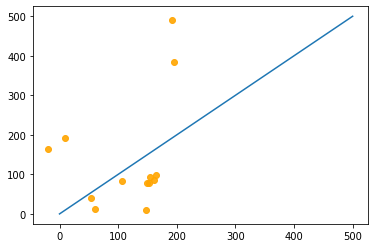

In [141]:
split_and_validate(X_selected, y_selected, df_M_valid, Lasso, 5)

In [512]:
df_play_1.sample(5)

,State,City,Total_Avg_Review,D1,Median_Income_2018,Population_2017,Total_Res_count,Res_count_sq,Income_sq,Review_sq
59,CA,San Leandro,238.528205,100.0,81722.0,89683.0,195.0,38025.0,6.678485e+09,56895.704642
8,AZ,Scottsdale,147.926698,473.0,88071.0,255315.0,1487.0,2211169.0,7.756501e+09,21882.307996
27,CA,Fremont,398.602837,104.0,136718.0,237815.0,282.0,79524.0,1.869181e+10,158884.221568
69,CA,Torrance,444.320175,61.0,96492.0,145181.0,228.0,51984.0,9.310706e+09,197420.418302
79,TX,Houston,490.015038,67.0,51203.0,2326090.0,399.0,159201.0,2.621747e+09,240114.737068


In [516]:
df_play_1.iloc[:,2].std()

217.29778755036511